In [1]:
import lmdb
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import torch
import torchvision.transforms as T
import os
from data import BedsoreDataset
import torchvision

/home/zrway/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/home/zrway/anaconda3/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumP

### section 1

In [4]:
image_list = Path('data/VOCdevkit/VOC2007/JPEGImages/').rglob('*.jpg')
image_list = list(image_list)

In [2]:
# creat lmdb dataset

env = lmdb.open('JPEGImages_db',map_size=int(1e10))
for i in tqdm(image_list):
    name = i.name[:-4]
    with open(i, 'rb') as f:
        image_bin = f.read()
    with env.begin(write=True) as txn:
        txn.put(name.encode(), image_bin)
env.close()

100%|██████████| 1528/1528 [00:04<00:00, 344.81it/s]


In [9]:
# save arr to  lmdb dataset

env = lmdb.open('Byte_db',map_size=int(1e11))
for i in tqdm(image_list):
    name = i.name[:-4]
    arr = cv2.imread(str(i))
    arr = arr.tobytes()
    with env.begin(write=True) as txn:
        txn.put(name.encode(), arr)
env.close()

100%|██████████| 1528/1528 [02:03<00:00, 12.32it/s]


In [6]:
%%time
for i in tqdm(image_list):
    image = Image.open(i)
    arr = np.array(image)

100%|██████████| 1528/1528 [01:22<00:00, 18.63it/s]

CPU times: user 1min 12s, sys: 9.31 s, total: 1min 22s
Wall time: 1min 22s


In [8]:
## read lmdb
%%time
env = lmdb.open('JPEGImages_db')
with env.begin(write=False, buffers=True) as txn:
    for key, value in tqdm(txn.cursor()):
        name = key
        image_bin = value
        image_buf = np.frombuffer(image_bin, dtype=np.uint8)
        img = cv2.imdecode(image_buf, cv2.IMREAD_COLOR)
#         img = torch.from_numpy(img)
env.close()

1528it [01:04, 23.66it/s]

CPU times: user 1min 1s, sys: 3.76 s, total: 1min 4s
Wall time: 1min 4s


In [2]:

## read lmdb

env = lmdb.open('Byte_db')
with env.begin(write=False,buffers=True) as txn:
    for key, value in tqdm(txn.cursor()):
        name = key
        image_bin = value
        image_buf = np.frombuffer(image_bin, dtype=np.uint8)
env.close()

0it [00:00, ?it/s]


In [26]:
# load arr form lmdb
env = lmdb.open('JPEGImages')
with env.begin(write=False) as txn:
    image_bin = txn.get('0'.encode())
    image_buf = np.frombuffer(image_bin, dtype=np.uint8)
    img = cv2.imdecode(image_buf, cv2.IMREAD_COLOR)

/home/zrway/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/home/zrway/anaconda3/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumP

In [8]:
ds = torchvision.datasets.VOCDetection('data',year='2007',image_set='trainval')

In [ ]:
# make byte_db
env = lmdb.open('Byte_db',map_size=int(3e10))
with env.begin(write=True) as txn:
    for i,d in enumerate(tqdm(ds)):
        fname = d[1]['annotation']['filename'][:-4]
        mask_class_path = f'data/VOCdevkit/VOC2007/SegmentationClass/{fname}.png'
        mask_object_path = f'data/VOCdevkit/VOC2007/SegmentationObject/{fname}.png'
        if os.path.exists(mask_class_path):
            mask = Image.open(mask_object_path).convert('L')
            mask_class = Image.open(mask_class_path).convert('L')
            mask_byte = np.array(mask).tobytes()
            mask_class_byte = np.array(mask_class).tobytes()
            arr = np.array(d[0])
            byte = arr.tobytes()
            anno = str(d[1])
            txn.put(f'data_{i}'.encode(), byte)
            txn.put(f'anno_{i}'.encode(), anno.encode())
            txn.put(f'mask_{i}'.encode(), mask_byte)
            txn.put(f'mask_class_{i}'.encode(), mask_class_byte)
        else:
            print(fname,'not exist')
env.close()

In [27]:
id = 3
env = lmdb.open('data/arr_lmdb')
with env.begin(write=False) as txn:
    arr = txn.get(f'data_{id}'.encode())
    anno = txn.get(f'anno_{id}'.encode())
    anno = eval(anno)
    w = anno['annotation']['size']['width']
    h = anno['annotation']['size']['height']
    arr = np.frombuffer(arr, dtype=np.uint8)
    arr = arr.reshape(int(h),int(w),3)
    
    mask = txn.get(f'mask_{id}'.encode())
    if mask is not None:
        mask = np.frombuffer(mask, dtype=np.uint8)
        mask = mask.reshape(int(h),int(w))

        mask_class = txn.get(f'mask_class_{id}'.encode())
        mask_class = np.frombuffer(mask_class, dtype=np.uint8)
        mask_class = mask_class.reshape(int(h),int(w))

env.close()

TypeError: eval() arg 1 must be a string, bytes or code object

In [26]:
np.unique(mask_class)

array([  0, 137, 173], dtype=uint8)

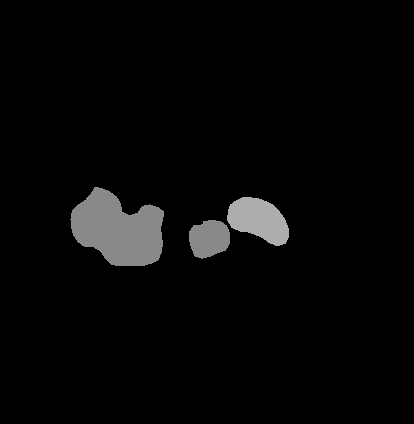

In [20]:
Image.fromarray(mask_class)

### lmdb数据集

In [2]:
from data import BedsoreDataset,BedsoreDataModule
from utils import batch2pil,draw_bbox
import utils

import copy
import os
import pathlib

import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split
import albumentations as album
from albumentations.pytorch import ToTensorV2, ToTensor
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [13]:
from data import BedsoreLMDB,BedsoreLMDBDataModule
trans_prob=0.5
tfmc_train = album.Compose(
            [
#                  album.RandomScale(p=trans_prob, scale_limit=0.5),
#                  album.RandomShadow(p=trans_prob),
                album.RandomSizedBBoxSafeCrop(
                    800, 800, p=0.5, erosion_rate=0.2),
                album.HorizontalFlip(p=trans_prob),
                album.VerticalFlip(p=trans_prob),
                album.ShiftScaleRotate(p=trans_prob, rotate_limit=90),
                album.RandomBrightnessContrast(p=trans_prob),
                 album.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
                ToTensor()
            ],
            bbox_params=album.BboxParams(format='pascal_voc',
                                         label_fields=['category_ids']))

ds = BedsoreLMDB(transforms=tfmc_train, image_set='val',chunk_id=0, chunk_num=0, val=True)
dm = BedsoreLMDBDataModule('data',batch_size=8,num_valid=0,trans_prob=0.5,num_workers=8,chunk_num=10,chunk_id=1)

In [16]:
%%time
dl = dm.test_dataloader()
for i in tqdm(dl):
    pass

100%|██████████| 100/100 [00:04<00:00, 21.53it/s]

CPU times: user 313 ms, sys: 804 ms, total: 1.12 s
Wall time: 4.65 s


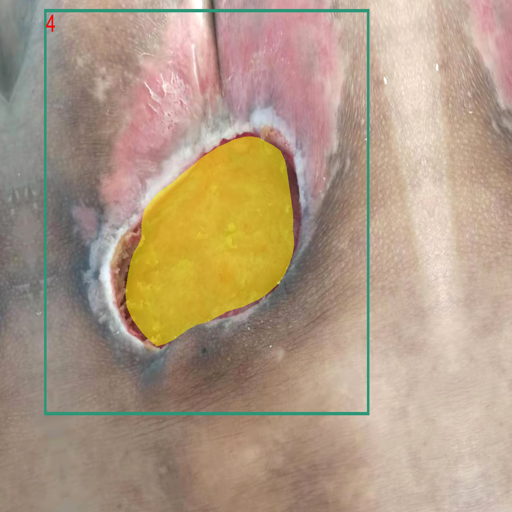

In [318]:
idx =53
image,target = ds[idx]
draw_bbox(image,target).resize((512,512))

### 普通数据集

In [9]:
from data import BedsoreDataset
from matplotlib import pyplot as plt

trans_prob=1
tfmc_train = album.Compose(
            [
#                 album.RandomSizedBBoxSafeCrop(
#                     800, 800, p=1, erosion_rate=0),
#                 album.HorizontalFlip(p=0.5),
#                 album.VerticalFlip(p=0.5),
#                 album.ShiftScaleRotate(p=trans_prob, rotate_limit=180),
#                 album.RandomBrightnessContrast(p=trans_prob),
#                  album.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
                ToTensor()
            ],
            bbox_params=album.BboxParams(format='pascal_voc',
                                         label_fields=['category_ids']))
dsb = BedsoreDataset(transforms=tfmc_train,image_set='train')
dl = DataLoader(dsb,batch_size=8,num_workers=8, collate_fn=utils.collate_fn)

In [10]:
### %%time
# for i in tqdm(dl):
#     pass

In [35]:
image,target = dsb[370]
print(target['fname'])

B03_00024


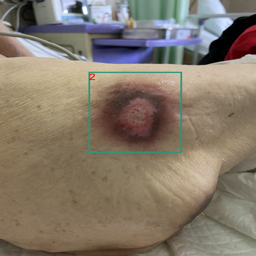

In [36]:
draw_bbox(image,target).resize((256,256))

In [158]:
dsb[idx][1]

{'boxes': tensor([[132.9084, 401.6533, 299.1453, 655.9618],
         [462.1345, 384.9844, 658.6649, 660.3920]]),
 'labels': tensor([6, 6]),
 'image_id': tensor([0]),
 'fname': 'B01_00001',
 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]])}

In [86]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

category_id_to_name = {2: 'cat', 3: 'dog', 6: 'cdog', 4: '4cdog'}
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)